In [1]:
%pylab inline
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time
import threshold_BGLSS
import matplotlib.pyplot as plt
import seaborn as sns

fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
importlib.reload(threshold_BGLSS)
from threshold_BGLSS import *

## Define the PDE

In [3]:
def advection_rhs(u, t, params):
    
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))

    return real(deriv)

## Solve the PDE

In [4]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

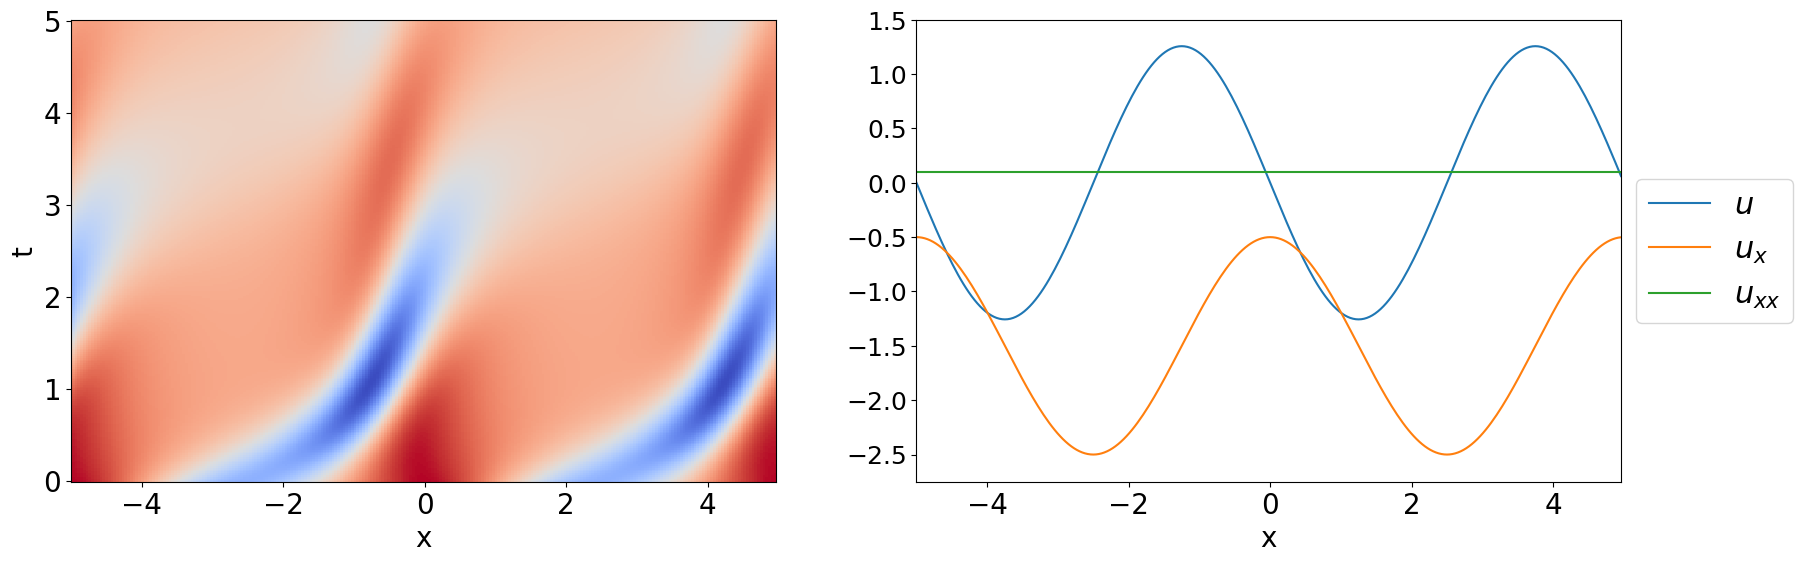

In [5]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(20,6))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()
fig.savefig("AD.png", dpi=200)

## Build the Regression Model

In [6]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'Fourier')

/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:310: ComplexWarning: Casting complex values to real discards the imaginary part
  elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(u[:,i]))


In [7]:
Theta_grouped = [real(Theta[n*np.arange(m)+j,:]) for j in range(n)]
Ut_grouped = [real(Ut[n*np.arange(m)+j]) for j in range(n)]
Xs = Theta_grouped
ys = Ut_grouped

In [8]:
xi_true = np.zeros((len(rhs_des),m))
i_u = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u'][0]
i_u_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{x}'][0]
i_u_xx = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{xx}'][0]

xi_true[i_u,:] = u_true
xi_true[i_u_x,:] = u_x_true
xi_true[i_u_xx,:] = u_xx_true

In [9]:
xi, lam, loss, path, coef, remain = thresholdBGLSS_combined(Theta_grouped, Ut_grouped, niter = 600, burnin = 100, threshold1 = 0.02, threshold2 = 0.08)

0
20
Update:
0
Lambda2:
0.9149637614976769

Update:
1
Lambda2:
0.5004520416572374

Update:
2
Lambda2:
0.2523271290218377

Update:
3
Lambda2:
0.13079172630323085

Update:
4
Lambda2:
0.07332487653645386

Update:
5
Lambda2:
0.04511107879405371

Update:
6
Lambda2:
0.03042696419689369

Update:
7
Lambda2:
0.022222375402979708

Update:
8
Lambda2:
0.017292831698497078

Update:
9
Lambda2:
0.014148303033935205

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
1

/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:206: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), loss_normalize)
/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:23: RuntimeWarning: invalid value encountered in true_divide
  rate = np.sum(variance, axis=1)/np.sum(mean**2, axis=1)


GE: 
[7.46297820e-01 7.92615078e-05 1.70140367e+00            nan
 1.36107566e-04 2.51677902e+00            nan            nan
 1.28168150e-02            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan]
[1, 4, 8]
0
3
Update:
0
Lambda2:
0.08084924156585847

Update:
1
Lambda2:
0.00996390749717595

Update:
2
Lambda2:
0.003348828497416191

Update:
3
Lambda2:
0.0019286911579748382

Update:
4
Lambda2:
0.0014461709685691926

Update:
5
Lambda2:
0.0012612705022368824

Update:
6
Lambda2:
0.0011778651025090854

Update:
7
Lambda2:
0.0011356887902797832

Update:
8
Lambda2:
0.001113239269110598

Update:
9
Lambda2:
0.0011148783300252883

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
9

In [10]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi_sgtr = Xi[np.argmin(Losses)]

/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:601: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:571: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


MSE:  1.9255640787146399e-07


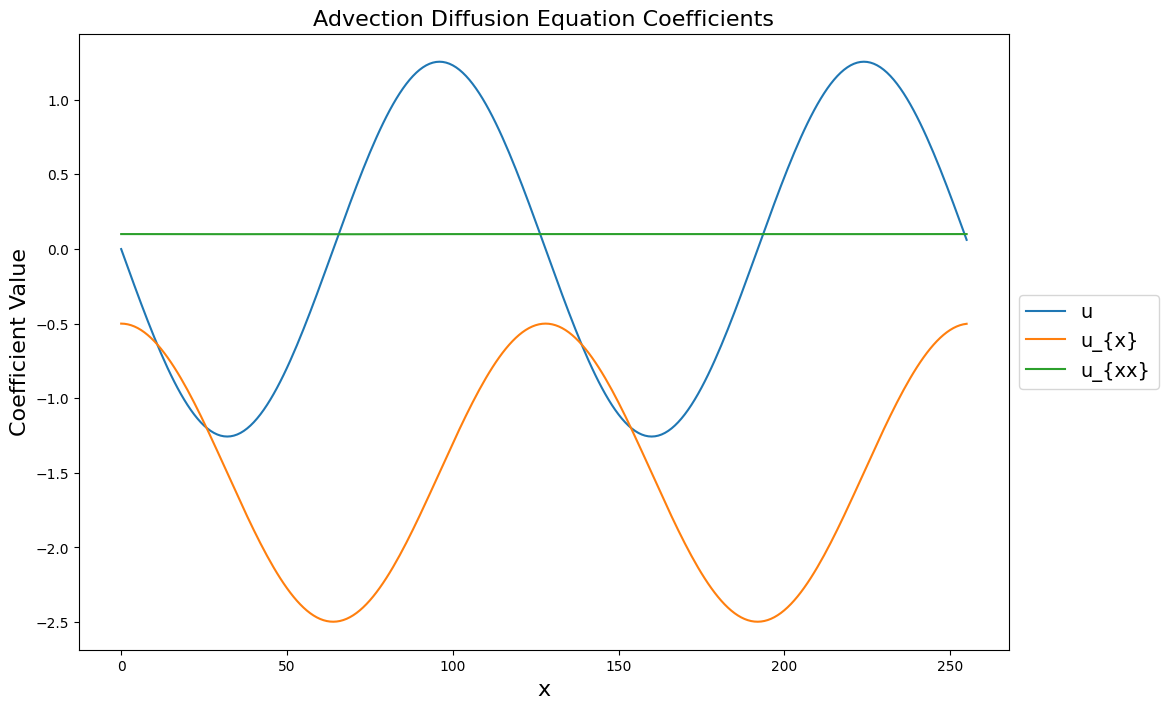

In [11]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_sgtr.shape[0]): 
    if np.linalg.norm(xi_sgtr[j,:]) > 10**-10:
        plot(xi_sgtr[j,:], label = rhs_des[j])

title('Advection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_sgtr = Norm(xi_sgtr-xi_true)**2/(m*len(rhs_des))

print('MSE: ', mse_clean_sgtr)

In [12]:
D = Theta_grouped[0].shape[1]
groups = [[j+D*i for i in range(n)] for j in range(D)]

Xi_lasso,Lam_lasso,Losses_lasso,Histories_Lasso = TrainGroupLasso(Theta_grouped, Ut_grouped, groups)
xi_lasso = Xi_lasso[np.argmin(Losses_lasso)]

/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:456: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:436: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  z[nz_coords,j] = np.linalg.lstsq(As[j][:, nz_coords], bs[j])[0][:,0]


MSE:  1.9255640787145589e-07


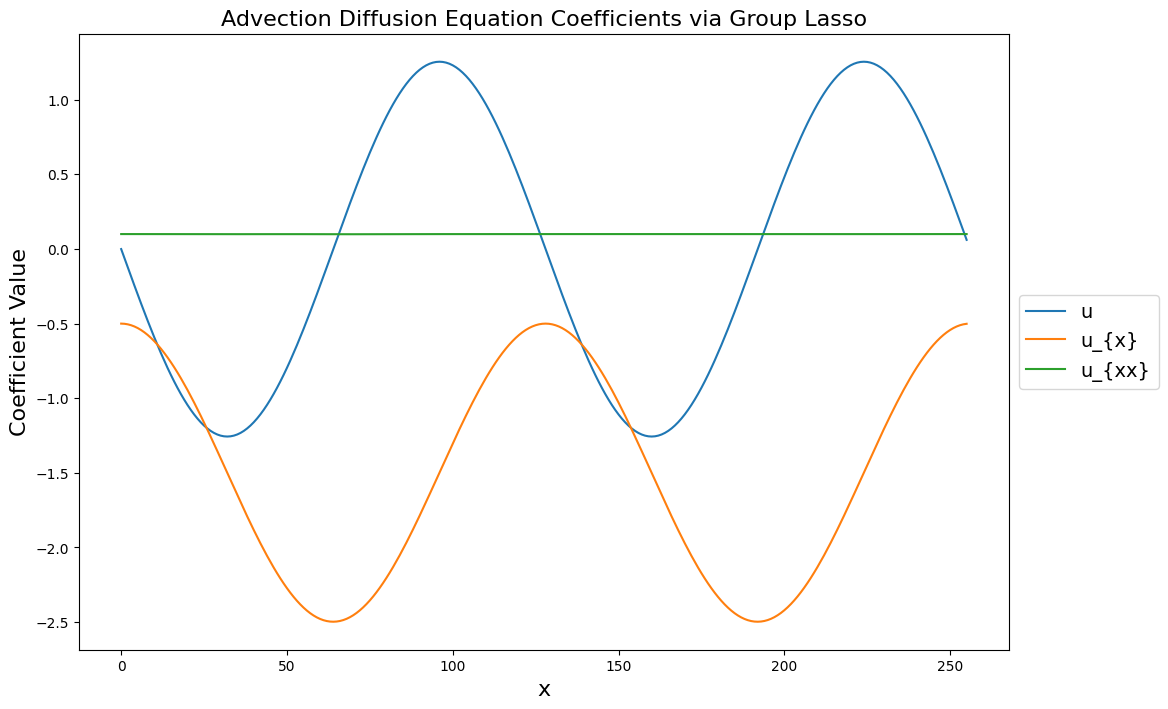

In [13]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso.shape[0]): 
    if np.linalg.norm(xi_lasso[j,:]) > 10**-10:
        plot(xi_lasso[j,:], label = rhs_des[j])

title('Advection Diffusion Equation Coefficients via Group Lasso', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_gl = Norm(xi_lasso-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_gl)

/tmp/ipykernel_483916/1726915011.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coef[7, :], color = 'r', kde=True)


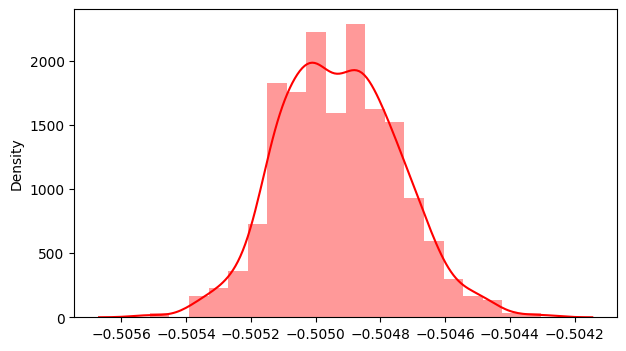

In [14]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
sns.distplot(coef[7, :], color = 'r', kde=True)
fig.savefig("hist_AD.png", dpi=200)

In [15]:
np.median(coef[7, :])

-0.5049284037813889

/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mb, bins=bins, kde=kde)


[-0.50496306 -0.50490645]
-0.5049314582862134


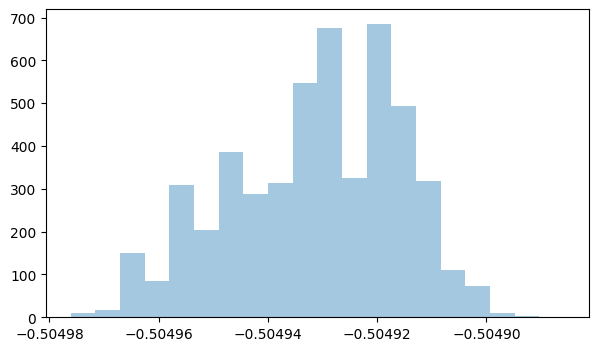

In [16]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
ci, mean = bootstrapMedian(coef[7, :], show_hist = True, bins = 20)
fig.savefig("hist_bootstrap_AD.png", dpi=200)
print(ci)
print(mean)

In [17]:
ci, means = getCI(coef, m)

In [18]:
xi.shape

(3, 256)

In [19]:
d = len(rhs_des)

In [20]:
std = np.std(coef, axis=1, ddof=1).reshape(m, xi.shape[0]).T

In [21]:
np.mean(std[0,:])

0.0005765409345116944

In [22]:
np.mean(-ci[0][0,:]+ci[1][0,:])

0.00012489010887570354

MSE:  1.937408147845651e-07


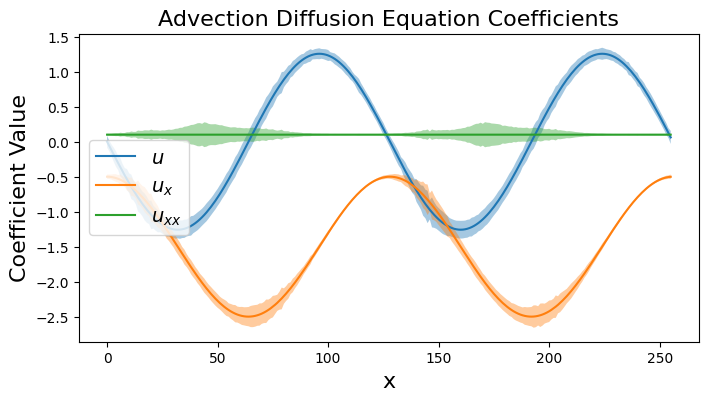

In [23]:
xi_bglss = np.zeros((d, m))

pylab.rcParams['figure.figsize'] = (8, 4)
fig, ax = plt.subplots()
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(xi[j,:], label = r'$'+rhs_des[remain[j]]+'$')
        fill_between(range(len(xi[j,:])), xi[j,:]-200*std[j, :], xi[j,:]+200*std[j, :], alpha=0.4)
        xi_bglss[remain[j], :] = xi[j,:]

title('Advection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', fontsize = 14)

mse_clean_tbglss = Norm(xi_bglss-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_tbglss)
plt.show()
fig.savefig("tbglss-clean-AD.png", dpi=200)

In [24]:
un = u + 0.01*np.std(u)*np.random.randn(n,m)

In [25]:
# Build linear systems
wx = 10  
wt = 10  

deg_x = 6
deg_t = 4
 
Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = deg_x, deg_t = deg_t, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [26]:
# Group by location
Thetan_grouped = [real(Thetan[n2*np.arange(m2)+j,:]) for j in range(n2)]
Utn_grouped = [real(Utn[n2*np.arange(m2)+j]) for j in range(n2)]

In [27]:
xi_n, lam_n, loss_n, path_n, coef_n, remain_n = thresholdBGLSS(Thetan_grouped, Utn_grouped, niter = 600, burnin = 100, threshold = 10**-2)

0
20
Update:
0
Lambda2:
1.2550876684530414

Update:
1
Lambda2:
1.3978442529886685

Update:
2
Lambda2:
1.482204545965442

Update:
3
Lambda2:
1.5422734476004731

Update:
4
Lambda2:
1.5821926409859681

Update:
5
Lambda2:
1.6147574637465485

Update:
6
Lambda2:
1.632134023640556

Update:
7
Lambda2:
1.6564951381633823

Update:
8
Lambda2:
1.6690842610241505

Update:
9
Lambda2:
1.6732847721269586

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
1

/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:206: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), loss_normalize)


[0, 1, 2, 4, 5, 8, 9]
0
7
Update:
0
Lambda2:
1.7741900459653888

Update:
1
Lambda2:
2.043315759846062

Update:
2
Lambda2:
2.1961078184635165

Update:
3
Lambda2:
2.279140526723622

Update:
4
Lambda2:
2.3066764478345134

Update:
5
Lambda2:
2.327210755003416

Update:
6
Lambda2:
2.3335856116740934

Update:
7
Lambda2:
2.3444527277183136

Update:
8
Lambda2:
2.3537943235337653

Update:
9
Lambda2:
2.344023009518321

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
17

In [28]:
remain_n

[0, 1, 2, 4, 5, 8, 9]

In [29]:
ci_n, means_n = getCI(coef_n, m2)

MSE:  0.006055784129536466


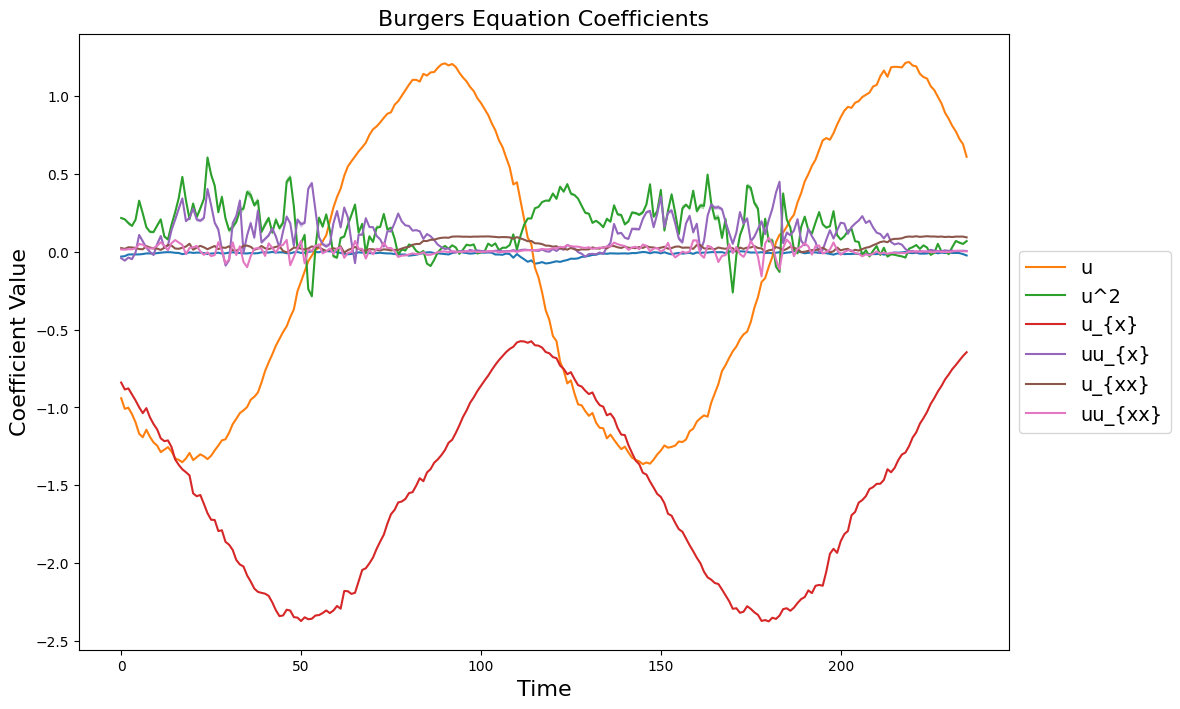

In [30]:
xi_bglss = np.zeros((d, m2))

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = rhs_des[remain_n[j]])
        fill_between(range(len(xi_n[j,:])), ci_n[1][j, :], ci_n[0][j, :], alpha=0.4)
        xi_bglss[remain_n[j], :] = xi_n[j,:]

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_tbglss = Norm(xi_bglss-xi_true[:,wt:-wt])**2/(m2*len(rhs_des))
print('MSE: ', mse_noise_tbglss)

In [31]:
groupError(coef_n, m2)

array([7.22805546e-02, 6.80615169e-04, 1.91542145e-01, 1.46469066e-04,
       2.51274903e-01, 2.01422392e-02, 6.12762729e-01])

In [32]:
totalError(coef_n, m2)

1.148829655203056

In [33]:
X_n1, Lam_n1, Losses_n1, Coef_n1, Remain_n1, TE_n1, Threshold_n1 = TrainBGLSS_findt1(Thetan_grouped, Utn_grouped, num_threshold = 21, max_threshold = 0.1, min_threshold = 0, niter = 600, burnin = 100)

[0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1]
threshold:
0.0
0
20
Update:
0
Lambda2:
1.2550876684530414

Update:
1
Lambda2:
1.3978442529886685

Update:
2
Lambda2:
1.482204545965442

Update:
3
Lambda2:
1.5422734476004731

Update:
4
Lambda2:
1.5821926409859681

Update:
5
Lambda2:
1.6147574637465485

Update:
6
Lambda2:
1.632134023640556

Update:
7
Lambda2:
1.6564951381633823

Update:
8
Lambda2:
1.6690842610241505

Update:
9
Lambda2:
1.6732847721269586

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141

In [34]:
MSEs_n1 = getMSEs(X_n1, Remain_n1, xi_true[:,wt:-wt])

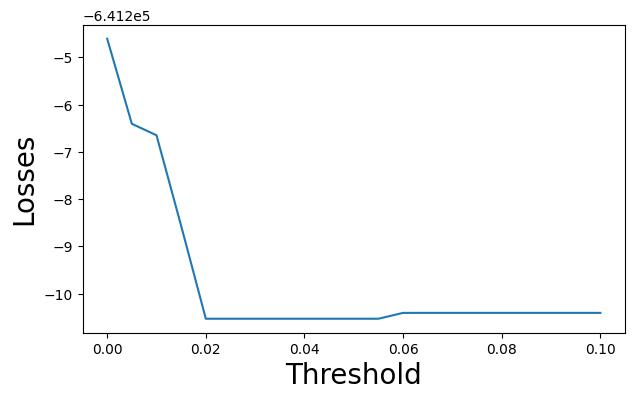

In [35]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
ax.plot(Threshold_n1, Losses_n1, label = 'threshold1 = 0')
xlabel('Threshold', fontsize = fontsize)
ylabel('Losses', fontsize = fontsize)
fig.savefig("Losses-1.png", dpi=200)

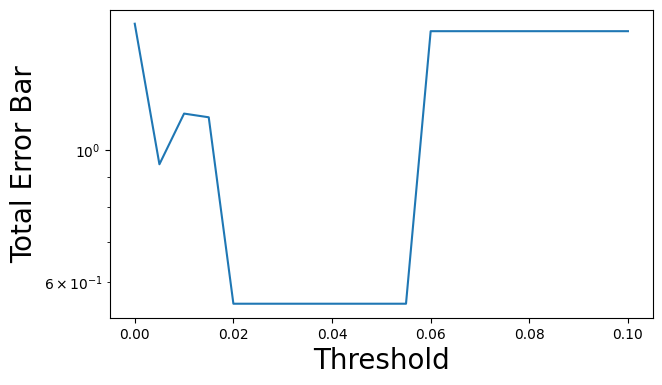

In [36]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(Threshold_n1, TE_n1, label = 'threshold1 = 0')
xlabel('Threshold', fontsize = fontsize)
ylabel('Total Error Bar', fontsize = fontsize)
pylab.show()
fig.savefig("TE-1.png", dpi=200)

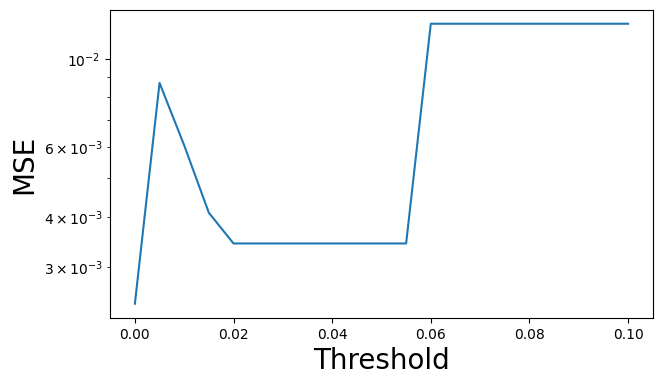

In [37]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(Threshold_n1, MSEs_n1, label = 'threshold1 = 0')
xlabel('Threshold', fontsize = fontsize)
ylabel('MSE', fontsize = fontsize)
pylab.show()
fig.savefig("MSE-1.png", dpi=200)

In [38]:
X_n2, Lam_n2, Losses_n2, Coef_n2, Remain_n2, TE_n2, Threshold_n2 = TrainBGLSS_findt2(Thetan_grouped, Utn_grouped, threshold1 = 0.01, num_threshold = 21, max_threshold = 0.23, min_threshold = 0.03, niter = 600, burnin = 100)

[0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23]
threshold:
0.03
0
20
Update:
0
Lambda2:
1.2550876684530414

Update:
1
Lambda2:
1.3978442529886685

Update:
2
Lambda2:
1.482204545965442

Update:
3
Lambda2:
1.5422734476004731

Update:
4
Lambda2:
1.5821926409859681

Update:
5
Lambda2:
1.6147574637465485

Update:
6
Lambda2:
1.632134023640556

Update:
7
Lambda2:
1.6564951381633823

Update:
8
Lambda2:
1.6690842610241505

Update:
9
Lambda2:
1.6732847721269586

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


/home/yifan/Documents/code_equation_learn/Experiments/threshold_BGLSS.py:23: RuntimeWarning: invalid value encountered in true_divide
  rate = np.sum(variance, axis=1)/np.sum(mean**2, axis=1)


GE: 
[1.28590543e-01 9.20630310e-04 3.93299505e-01            nan
 4.14161049e-04 1.89290110e-01            nan            nan
 3.28879035e-02 8.50499391e-01            nan            nan
 4.53701079e-03            nan            nan            nan
 3.44452931e-02            nan            nan            nan]
[1, 4]
0
2
Update:
0
Lambda2:
1.586762250770272

Update:
1
Lambda2:
1.9227698830947129

Update:
2
Lambda2:
2.143824644676937

Update:
3
Lambda2:
2.2500198244660967

Update:
4
Lambda2:
2.3302459051868887

Update:
5
Lambda2:
2.3479427780908897

Update:
6
Lambda2:
2.3440907493131484

Update:
7
Lambda2:
2.3591039362346473

Update:
8
Lambda2:
2.341387323788027

Update:
9
Lambda2:
2.3556781338012147

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1

115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Update:
0
Lambda2:
0.9469567035543931

Update:
1
Lambda2:
0.7880276658323524

Update:
2
Lambda2:
0.7142712880027008

Update:
3
Lambda2:
0.6825787971997169

Update:
4
Lambda2:
0.6668448595164325

Update:
5
Lambda2:
0.6543989718819994

Update:
6
Lambda2:
0.6496784768951384

Update:
7
Lambda2:
0.6562257598676696

Update:
8
Lambda2:
0.651470111031691

Update:
9
Lambda2:
0.6507740422312179

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
1

531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
GE: 
[3.34670911e-04 7.62147122e-05 8.10681585e-03]
totalError:
0.008517701469388406

threshold:
0.13
0
20
Update:
0
Lambda2:
1.2564955468025825

Update:
1
Lambda2:
1.4025756425467428

Update:
2
Lambda2:
1.4905426898511251

Update:
3
Lambda2:
1.5527991149558609

Update:
4
Lambda2:
1.5958831239809066

Update:
5
Lambda2:
1.6304449116331228

Update:
6
Lambda2:
1.6479785165136145

Update:
7
Lambda2:
1.6715429216559403

Update:
8
Lambda2:
1.6843088146723852

Update:
9
Lambda2:
1.6892069122807103

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
GE: 
[1.33541725e-01 8.44933532e-04 3.64873759e-01            nan
 3.82391570e-04 1.96556587e-01            nan            nan
 3.16513680e-02 8.57053425e-01            nan            nan
 4.60072844e-03            nan            nan            nan
 3.32088338e-02            nan            nan            nan]
[0, 1, 4, 8]
0
4
Update:
0
La

345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594


255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504


166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415


68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325


Update:
6
Lambda2:
1.6479785165136145

Update:
7
Lambda2:
1.6715429216559403

Update:
8
Lambda2:
1.6843088146723852

Update:
9
Lambda2:
1.6892069122807103

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
23

GE: 
[3.34670911e-04 7.62147122e-05 8.10681585e-03]
totalError:
0.008517701469388406

threshold:
0.2
0
20
Update:
0
Lambda2:
1.2564955468025825

Update:
1
Lambda2:
1.4025756425467428

Update:
2
Lambda2:
1.4905426898511251

Update:
3
Lambda2:
1.5527991149558609

Update:
4
Lambda2:
1.5958831239809066

Update:
5
Lambda2:
1.6304449116331228

Update:
6
Lambda2:
1.6479785165136145

Update:
7
Lambda2:
1.6715429216559403

Update:
8
Lambda2:
1.6843088146723852

Update:
9
Lambda2:
1.6892069122807103

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
15

513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
GE: 
[0.00041452 0.00013217 0.12625265 0.01219549]
totalError:
0.13899483526035167

threshold:
0.21
0
20
Update:
0
Lambda2:
1.2564955468025825

Update:
1
Lambda2:
1.4025756425467428

Update:
2
Lambda2:
1.4905426898511251

Update:
3
Lambda2:
1.5527991149558609

Update:
4
Lambda2:
1.5958831239809066

Update:
5
Lambda2:
1.6304449116331228

Update:
6
Lambda2:
1.6479785165136145

Update:
7
Lambda2:
1.6715429216559403

Update:
8
Lambda2:
1.6843088146723852

Update:
9
Lambda2:
1.6892069122807103

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55

425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
GE: 
[0.00041452 0.00013217 0.12625265 0.01219549]
totalError:
0.13899483526035167

threshold:
0.22
0
20
Update:
0
Lambda2:
1.2564955468025825

Update:
1
Lambda2:
1.4025756425467428

Update:
2
Lambda2:
1.4905426898511251

Update:
3
Lambda2:
1.5527991149558609

Update:
4
Lambda2:
1.5958831239809066



341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590


254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503


In [39]:
MSEs_n2 = getMSEs(X_n2, Remain_n2, xi_true[:,wt:-wt])

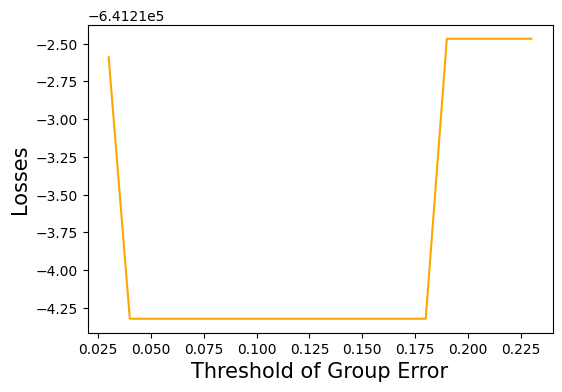

In [40]:
pylab.rcParams['figure.figsize'] = (6, 4)
fig, ax = plt.subplots()
ax.plot(Threshold_n2, Losses_n2, color = 'orange', label = 'threshold1 = 0.01')
xlabel('Threshold of Group Error', fontsize = fontsize-5)
ylabel('Losses', fontsize = fontsize-5)
fig.savefig("Losses-1.png", dpi=200)

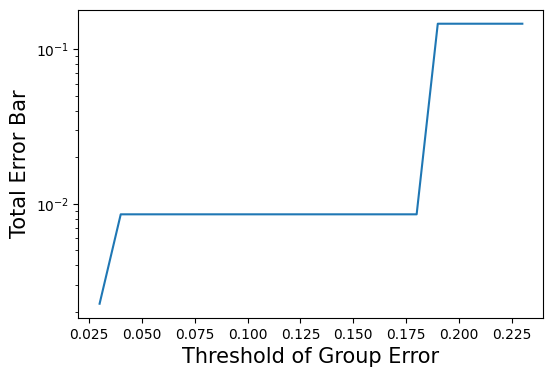

In [41]:
pylab.rcParams['figure.figsize'] = (6, 4)
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(Threshold_n2, TE_n2, label = 'threshold1 = 0.01')
xlabel('Threshold of Group Error', fontsize = fontsize-5)
ylabel('Total Error Bar', fontsize = fontsize-5)
pylab.show()
fig.savefig("TE-1.png", dpi=200)

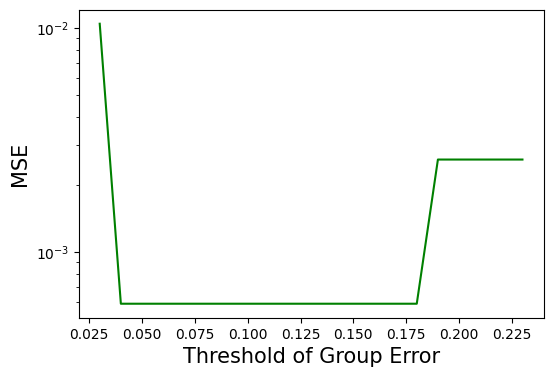

In [42]:
pylab.rcParams['figure.figsize'] = (6, 4)
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(Threshold_n2, MSEs_n2, color = 'green', label = 'threshold1 = 0')
xlabel('Threshold of Group Error', fontsize = fontsize-5)
ylabel('MSE', fontsize = fontsize-5)
pylab.show()
fig.savefig("MSE-1.png", dpi=200)

In [43]:
X_n3, Lam_n3, Losses_n3, Coef_n3, Remain_n3, TE_n3, Threshold_n3 = TrainBGLSS_findt2(Thetan_grouped, Utn_grouped, threshold1 = 0.03, num_threshold = 21, max_threshold = 0.22, min_threshold = 0.02, niter = 600, burnin = 100)

[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09000000000000001, 0.1, 0.11, 0.12000000000000001, 0.13, 0.13999999999999999, 0.15, 0.16, 0.16999999999999998, 0.18, 0.19, 0.19999999999999998, 0.21, 0.22]
threshold:
0.02
0
20
Update:
0
Lambda2:
1.2550876684530414

Update:
1
Lambda2:
1.3978442529886685

Update:
2
Lambda2:
1.482204545965442

Update:
3
Lambda2:
1.5422734476004731

Update:
4
Lambda2:
1.5821926409859681

Update:
5
Lambda2:
1.6147574637465485

Update:
6
Lambda2:
1.632134023640556

Update:
7
Lambda2:
1.6564951381633823

Update:
8
Lambda2:
1.6690842610241505

Update:
9
Lambda2:
1.6732847721269586

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


In [44]:
X_n4, Lam_n4, Losses_n4, Coef_n4, Remain_n4, TE_n4, Threshold_n4 = TrainBGLSS_findt2(Thetan_grouped, Utn_grouped, threshold1 = 0.07, num_threshold = 21, max_threshold = 0.22, min_threshold = 0.02, niter = 600, burnin = 100)

[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09000000000000001, 0.1, 0.11, 0.12000000000000001, 0.13, 0.13999999999999999, 0.15, 0.16, 0.16999999999999998, 0.18, 0.19, 0.19999999999999998, 0.21, 0.22]
threshold:
0.02
0
20
Update:
0
Lambda2:
1.2550876684530414

Update:
1
Lambda2:
1.3978442529886685

Update:
2
Lambda2:
1.482204545965442

Update:
3
Lambda2:
1.5422734476004731

Update:
4
Lambda2:
1.5821926409859681

Update:
5
Lambda2:
1.6147574637465485

Update:
6
Lambda2:
1.632134023640556

Update:
7
Lambda2:
1.6564951381633823

Update:
8
Lambda2:
1.6690842610241505

Update:
9
Lambda2:
1.6732847721269586

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


In [45]:
MSEs_n2 = getMSEs(X_n2, Remain_n2, xi_true[:,wt:-wt])
MSEs_n3 = getMSEs(X_n3, Remain_n3, xi_true[:,wt:-wt])
MSEs_n4 = getMSEs(X_n4, Remain_n4, xi_true[:,wt:-wt])

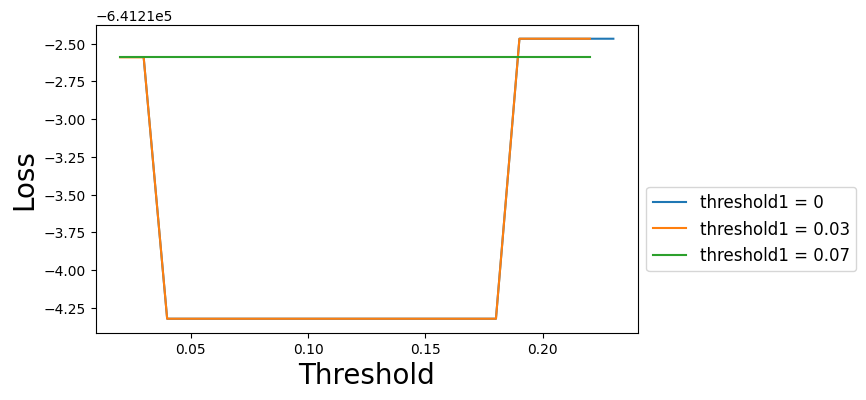

In [46]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
plot(Threshold_n2, Losses_n2, label = 'threshold1 = 0')
plot(Threshold_n3, Losses_n3, label = 'threshold1 = 0.03')
plot(Threshold_n4, Losses_n4, label = 'threshold1 = 0.07')
xlabel('Threshold', fontsize = fontsize)
ylabel('Loss', fontsize = fontsize)
legend( bbox_to_anchor=(1, 0.5), fontsize = 12)
pylab.show()
fig.savefig("Loss-2.png", dpi=200)

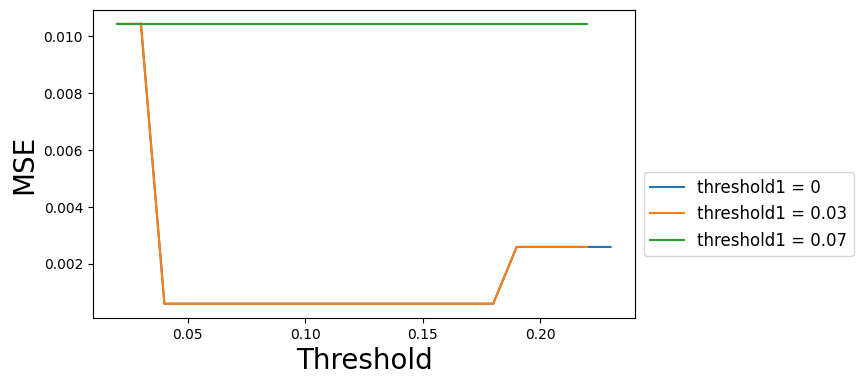

In [47]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
plot(Threshold_n2, MSEs_n2, label = 'threshold1 = 0')
plot(Threshold_n3, MSEs_n3, label = 'threshold1 = 0.03')
plot(Threshold_n4, MSEs_n4, label = 'threshold1 = 0.07')
xlabel('Threshold', fontsize = fontsize)
ylabel('MSE', fontsize = fontsize)
legend( bbox_to_anchor=(1, 0.5), fontsize = 12)
pylab.show()
fig.savefig("MSE-2.png", dpi=200)

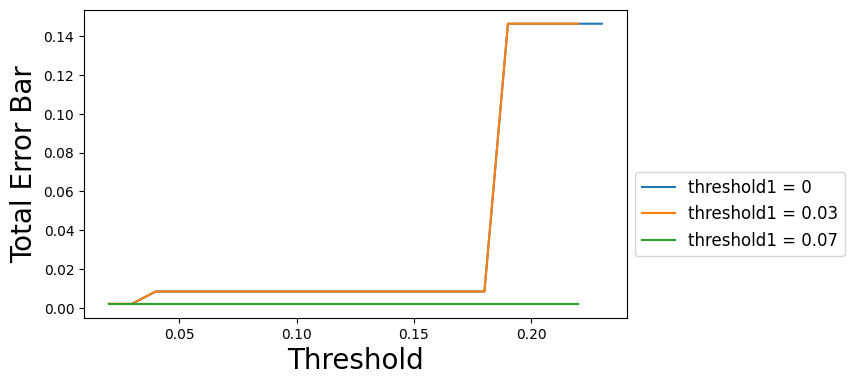

In [48]:
pylab.rcParams['figure.figsize'] = (7, 4)
fig, ax = plt.subplots()
plot(Threshold_n2, TE_n2, label = 'threshold1 = 0')
plot(Threshold_n3, TE_n3, label = 'threshold1 = 0.03')
plot(Threshold_n4, TE_n4, label = 'threshold1 = 0.07')
xlabel('Threshold', fontsize = fontsize)
ylabel('Total Error Bar', fontsize = fontsize)
legend( bbox_to_anchor=(1, 0.5), fontsize = 12)
pylab.show()
fig.savefig("MSE-2.png", dpi=200)

MSE:  0.0025873262239206967


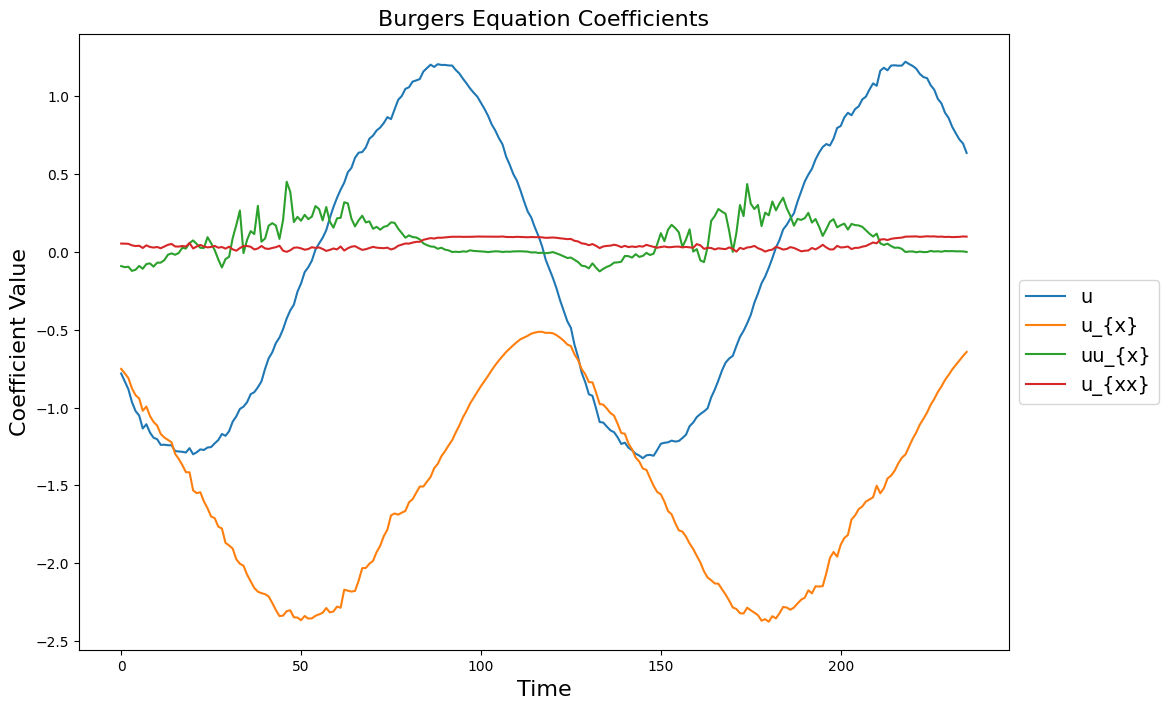

In [49]:
xi_n2 = X_n2[-1]
remain_n2 = Remain_n2[-1]
xi_bglss = np.zeros((d, m2))

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n2.shape[0]): 
    if np.linalg.norm(xi_n2[j,:]) > 10**-10:
        plot(xi_n2[j,:], label = rhs_des[remain_n2[j]])
#         fill_between(range(len(xi_n[j,:])), ci_n[1][j, :], ci_n[0][j, :], alpha=0.4)
        xi_bglss[remain_n2[j], :] = xi_n2[j,:]

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_tbglss = Norm(xi_bglss-xi_true[:,wt:-wt])**2/(m2*len(rhs_des))
print('MSE: ', mse_noise_tbglss)

In [50]:
xi_tb_n, lam_tb_n, loss_tb_n, path_tb_n, coef_tb_n, remain_tb_n = thresholdBGLSS_combined(Thetan_grouped, Utn_grouped, niter = 600, burnin = 100, threshold1 = 0.02, threshold2 = 0.08)

0
20
Update:
0
Lambda2:
1.2550876684530414

Update:
1
Lambda2:
1.3978442529886685

Update:
2
Lambda2:
1.482204545965442

Update:
3
Lambda2:
1.5422734476004731

Update:
4
Lambda2:
1.5821926409859681

Update:
5
Lambda2:
1.6147574637465485

Update:
6
Lambda2:
1.632134023640556

Update:
7
Lambda2:
1.6564951381633823

Update:
8
Lambda2:
1.6690842610241505

Update:
9
Lambda2:
1.6732847721269586

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
1

In [51]:
std_tb_n = np.std(coef_tb_n, axis=1, ddof=1).reshape(m2,xi_tb_n.shape[0]).T

MSE:  0.0005880418373052548


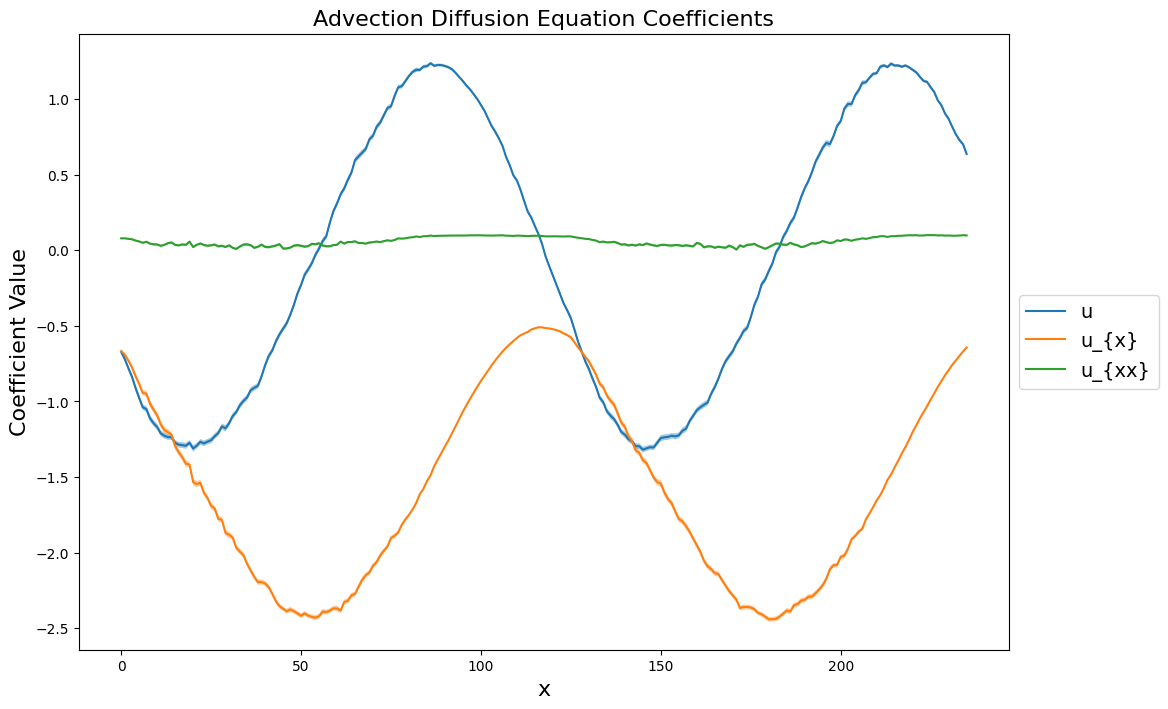

In [52]:
xi_bglss_n = np.zeros((d, m2))

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_tb_n.shape[0]): 
    if np.linalg.norm(xi_tb_n[j,:]) > 10**-10:
        plot(xi_tb_n[j,:], label = rhs_des[remain_tb_n[j]])
        fill_between(range(len(xi_tb_n[j,:])), xi_tb_n[j,:]-1*std_tb_n[j, :], xi_tb_n[j,:]+1*std_tb_n[j, :], alpha=0.4)
        xi_bglss_n[remain_tb_n[j], :] = xi_tb_n[j,:]

title('Advection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_tbglss = Norm(xi_bglss_n-xi_true[:,wt:-wt])**2/(m2*len(rhs_des))
print('MSE: ', mse_noise_tbglss)

In [53]:
Xi_sgtr_n,Tol_sgtr_n,Losses_sgtr_n = TrainSGTRidge(Thetan_grouped, Utn_grouped)
xi_sgtr_n = Xi_sgtr_n[np.argmin(Losses_sgtr_n)]

/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:601: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:571: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


MSE:  0.010377194935909578


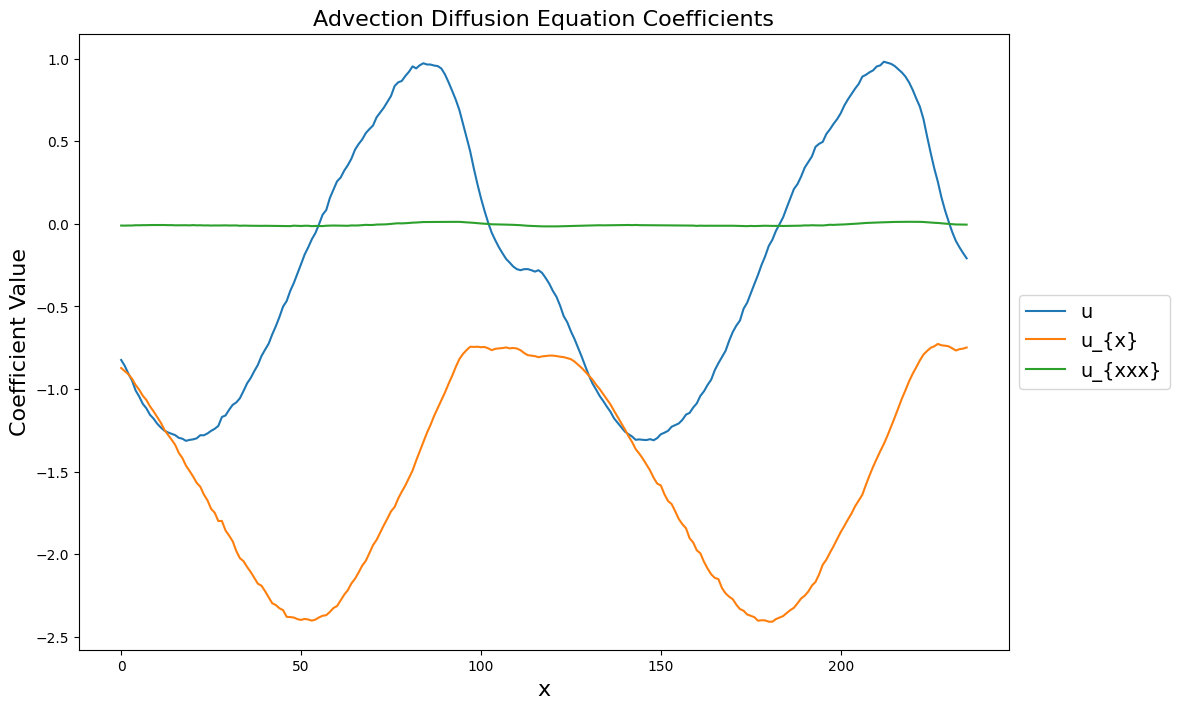

In [54]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_sgtr_n.shape[0]): 
    if np.linalg.norm(xi_sgtr_n[j,:]) > 10**-10:
        plot(xi_sgtr_n[j,:], label = rhs_des[j])

title('Advection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_sgtr_n-xi_true[:,wt:-wt])**2/(m2*16)

print('MSE: ', mse_noise_sgtr)

In [55]:
D = Theta_grouped[0].shape[1]
groups = [[j+D*i for i in range(n2)] for j in range(D)]
Xi_lasso_n,Lam_lasso_n,Losses_lasso_n,Histories_Lasso_n  = TrainGroupLasso(Thetan_grouped, Utn_grouped, groups)
xi_lasso_n = Xi_lasso_n[np.argmin(Losses_lasso_n)]

/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:456: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/home/yifan/Documents/code_equation_learn/Experiments/parametric_pde_find.py:436: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  z[nz_coords,j] = np.linalg.lstsq(As[j][:, nz_coords], bs[j])[0][:,0]


MSE:  0.0007309382386128608


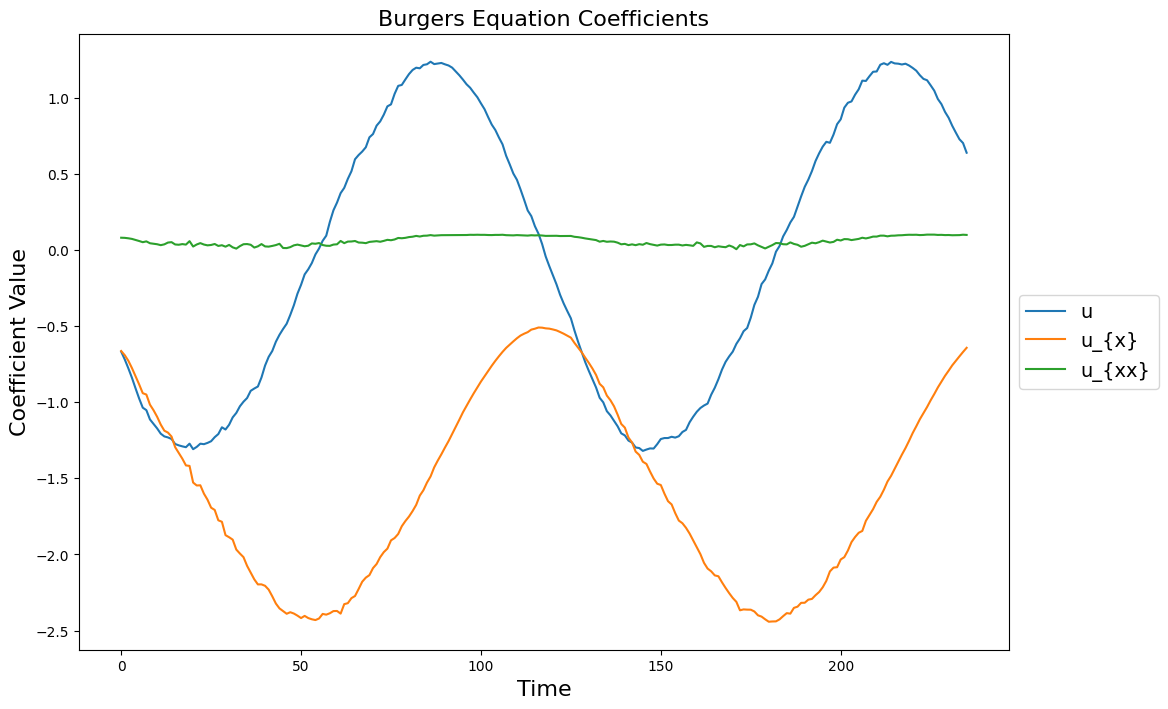

In [56]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso_n.shape[0]): 
    if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
        plot(xi_lasso_n[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_gl = Norm(xi_lasso_n-xi_true[:,wt:-wt])**2/(m2*16)
print('MSE: ', mse_noise_gl)

In [57]:
un = u + 0.05*np.std(u)*np.random.randn(n,m)

In [58]:
# Build linear systems
wx = 10  
wt = 10  

deg_x = 6
deg_t = 4
 
Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = deg_x, deg_t = deg_t, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [59]:
# Group by location
Thetan_grouped2 = [real(Thetan[n2*np.arange(m2)+j,:]) for j in range(n2)]
Utn_grouped2 = [real(Utn[n2*np.arange(m2)+j]) for j in range(n2)]

In [60]:
xi_tb_n2, lam_tb_n2, loss_tb_n2, path_tb_n2, coef_tb_n2, remain_tb_n2 = thresholdBGLSS_combined(Thetan_grouped2, Utn_grouped2, niter = 1100, burnin = 100, threshold1 = 0.01, threshold2 = 0.08)

0
20
Update:
0
Lambda2:
1.3660092859993813

Update:
1
Lambda2:
1.8481042773830927

Update:
2
Lambda2:
2.458638407916827

Update:
3
Lambda2:
3.2002277979848195

Update:
4
Lambda2:
4.083675992574231

Update:
5
Lambda2:
5.129001000522333

Update:
6
Lambda2:
6.291287685083783

Update:
7
Lambda2:
7.5990710526767895

Update:
8
Lambda2:
9.033545076697314

Update:
9
Lambda2:
10.412235835113968

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


In [61]:
std_tb_n2 = np.std(coef_tb_n2, axis=1, ddof=1).reshape(m2,xi_tb_n2.shape[0]).T

MSE:  0.023180930965403


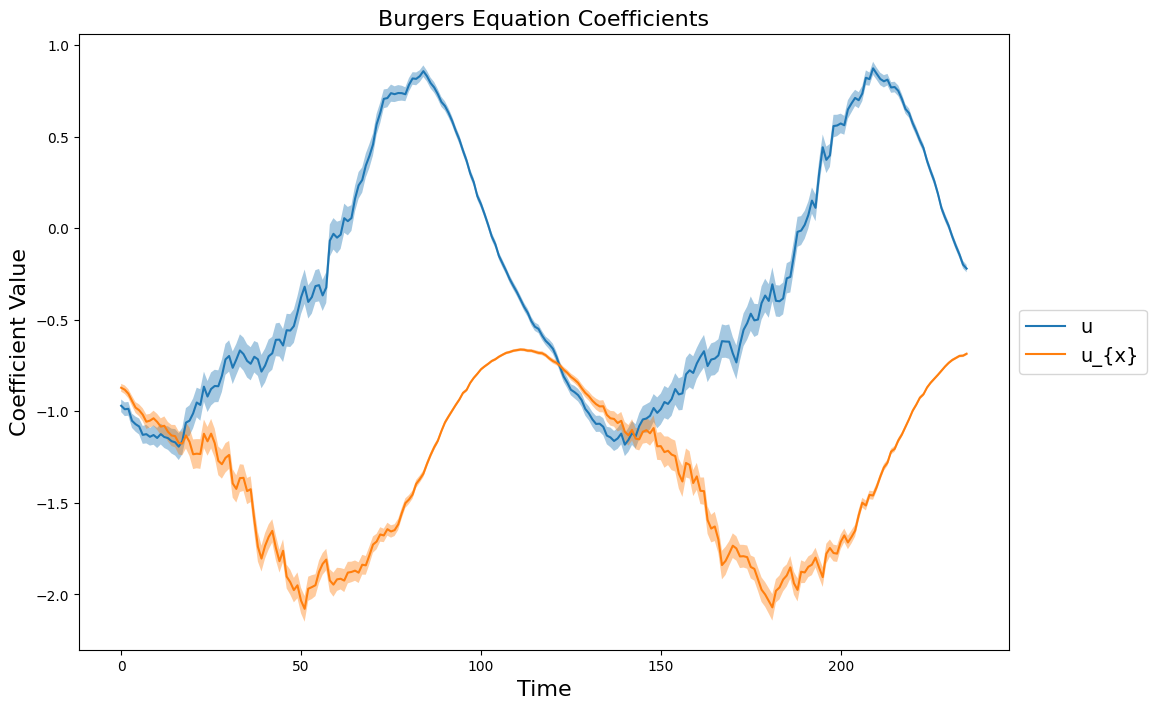

In [62]:
xi_bglss_n2 = np.zeros(xi_true[:,wt:-wt].shape)

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_tb_n2.shape[0]): 
    if np.linalg.norm(xi_tb_n2[j,:]) > 10**-10:
        plot(xi_tb_n2[j,:], label = rhs_des[remain_tb_n2[j]])
        fill_between(range(len(xi_tb_n2[j,:])), xi_tb_n2[j,:]-std_tb_n2[j, :], xi_tb_n2[j,:]+std_tb_n2[j, :], alpha=0.4)
        xi_bglss_n2[remain_tb_n2[j], :] = xi_tb_n2[j,:]

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_tbglss = Norm(xi_bglss_n2-xi_true[:,wt:-wt])**2/(m2*16)
print('MSE: ', mse_noise_tbglss)

In [63]:
Xi_sgtr_n2,Tol_sgtr_n2,Losses_sgtr_n2 = TrainSGTRidge(Thetan_grouped2, Utn_grouped2)
xi_sgtr_n2 = Xi_sgtr_n2[np.argmin(Losses_sgtr_n2)]

MSE:  0.025623401665224275


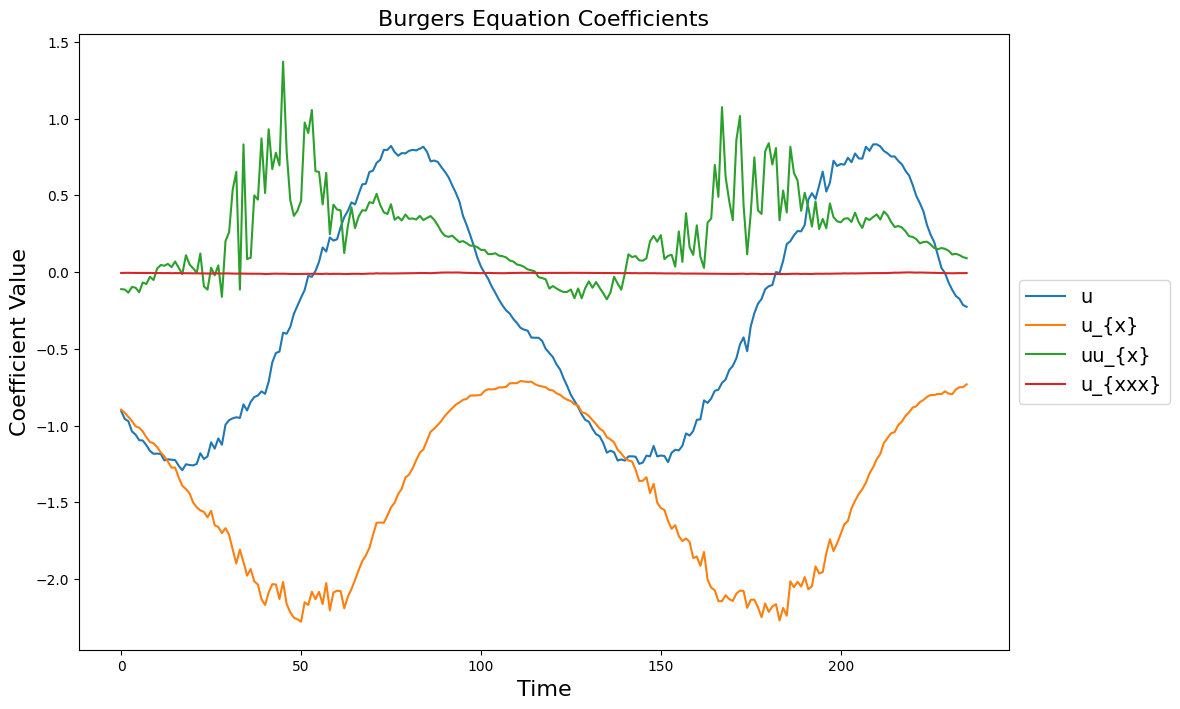

In [64]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_sgtr_n2.shape[0]): 
    if np.linalg.norm(xi_sgtr_n2[j,:]) > 10**-10:
        plot(xi_sgtr_n2[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_sgtr_n2-xi_true[:,wt:-wt])**2/(m2*16)

print('MSE: ', mse_noise_sgtr)

In [65]:
D = Theta_grouped[0].shape[1]
groups = [[j+D*i for i in range(n2)] for j in range(D)]
Xi_lasso_n2,Lam_lasso_n2,Losses_lasso_n2,Histories_Lasso_n2  = TrainGroupLasso(Thetan_grouped2, Utn_grouped2, groups)
xi_lasso_n2 = Xi_lasso_n2[np.argmin(Losses_lasso_n2)]

MSE:  0.005906847979383138


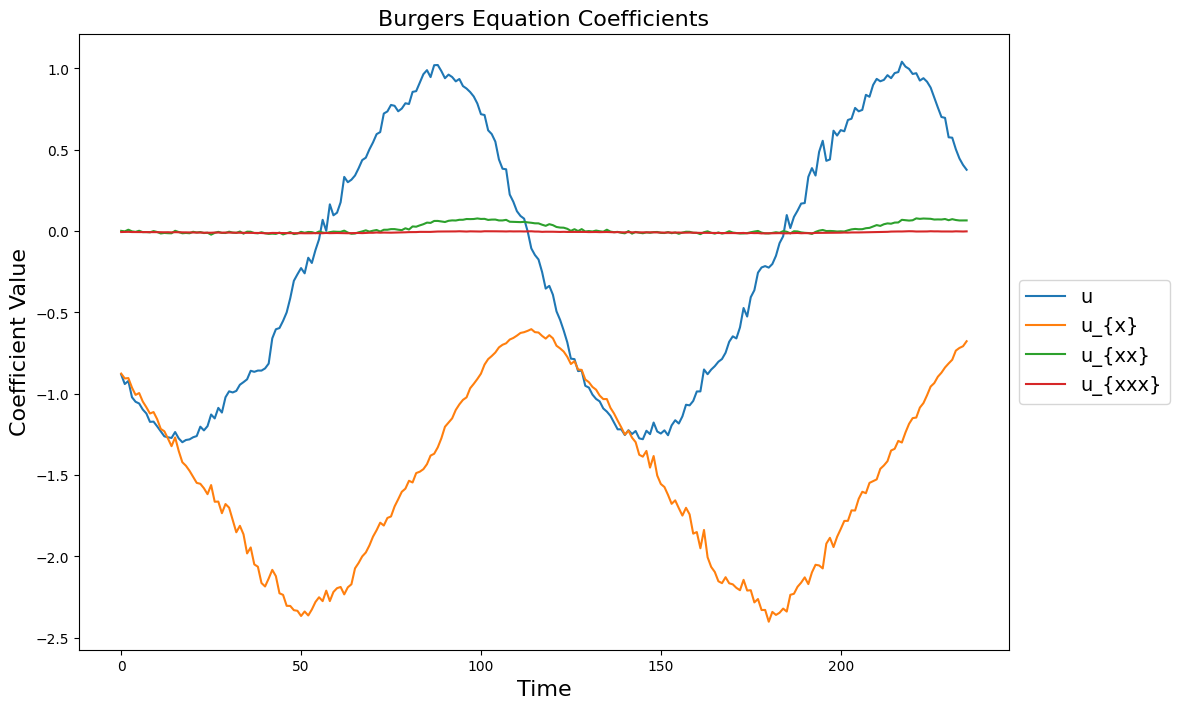

In [66]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso_n2.shape[0]): 
    if np.linalg.norm(xi_lasso_n2[j,:]) > 10**-10:
        plot(xi_lasso_n2[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_gl = Norm(xi_lasso_n2-xi_true[:,wt:-wt])**2/(m2*16)
print('MSE: ', mse_noise_gl)

ValueError: x and y must have same first dimension, but have shapes (256,) and (236,)

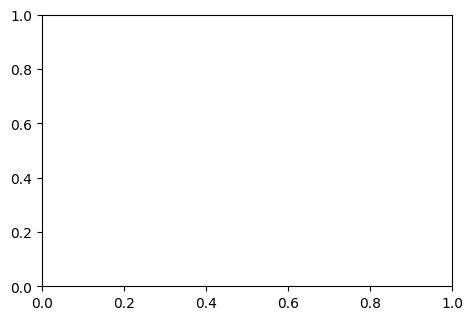

In [67]:
fig = figure(figsize = (18,12))
L = 8

for j in range(xi_true.shape[0]): 
    
    if np.linalg.norm(xi_bglss[j,:]) > 10**-10 or \
       np.linalg.norm(xi_lasso[j,:]) > 10**-10 or \
       np.linalg.norm(xi_sgtr[j,:]) > 10**-10 or \
       np.linalg.norm(xi_bglss_n[j,:]) > 10**-10 or \
       np.linalg.norm(xi_lasso_n[j,:]) > 10**-10 or \
       np.linalg.norm(xi_sgtr_n[j,:]) > 10**-10 or\
       np.linalg.norm(xi_bglss_n2[j,:]) > 10**-10 or \
       np.linalg.norm(xi_lasso_n2[j,:]) > 10**-10 or \
       np.linalg.norm(xi_sgtr_n2[j,:]) > 10**-10:
        
        subplot(3,3,1)
        if np.linalg.norm(xi_bglss[j,:]) > 10**-10:
            plot(x,xi_bglss[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            
        subplot(3,3,2)
        if np.linalg.norm(xi_bglss_n[j,:]) > 10**-10:
            plot(x[wx:-wx], xi_bglss_n[j,:], label =  r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            
        subplot(3,3,3)
        if np.linalg.norm(xi_bglss_n2[j,:]) > 10**-10:
            plot(x[wx:-wx], xi_bglss_n2[j,:], label =  r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            
        subplot(3,3,4)
        if np.linalg.norm(xi_sgtr[j,:]) > 10**-10:
            plot(x,xi_sgtr[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
        
        subplot(3,3,5)
        if np.linalg.norm(xi_sgtr_n[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_sgtr_n[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            
        subplot(3,3,6)
        if np.linalg.norm(xi_sgtr_n2[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_sgtr_n2[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            
        subplot(3,3,7)
        if np.linalg.norm(xi_lasso[j,:]) > 10**-10:
            plot(x,xi_lasso[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
        
        subplot(3,3,8)
        if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_lasso_n[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            
        subplot(3,3,9)
        if np.linalg.norm(xi_lasso_n2[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_lasso_n2[j,:], label = r'$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0])
            


subplot(3,3,1); xlim([-5, 5]); ylim([-2.6,1.5]); xticks(fontsize = 0); yticks(fontsize = fontsize); title(r'tBGL-SS, clean', fontsize = fontsize)
subplot(3,3,2); xlim([-5, 5]); ylim([-2.6,1.5]); xticks(fontsize = 0); yticks([]); title(r'tBGL-SS, 1% $\sigma_u$ noise', fontsize = fontsize)
subplot(3,3,3); xlim([-5, 5]); ylim([-2.6,1.5]); xticks(fontsize = 0); yticks([]); title(r'tBGL-SS, 5% $\sigma_u$ noise', fontsize = fontsize)
subplot(3,3,4); xlim([-5, 5]); ylim([-2.6,1.5]); xticks(fontsize = 0); yticks(fontsize = fontsize); title(r'SGTR, clean', fontsize = fontsize)
subplot(3,3,5); xlim([-5, 5]); ylim([-2.6,1.5]); xticks(fontsize = 0); yticks([]); title(r'SGTR,  1% $\sigma_u$ noise', fontsize = fontsize)
subplot(3,3,6); xlim([-5, 5]); ylim([-2.6,1.5]); xticks(fontsize = 0); yticks([]); title(r'SGTR, 5% $\sigma_u$ noise', fontsize = fontsize)
subplot(3,3,7); xlim([-5, 5]); ylim([-2.6,1.5]); xticks(fontsize = fontsize); yticks(fontsize = fontsize); xlabel(r'$x$', fontsize = fontsize+2); title(r'Group Lasso, clean', fontsize = fontsize)
subplot(3,3,8); xlim([-5, 5]); ylim([-2.6,1.5]); xticks(fontsize = fontsize); yticks([]); xlabel(r'$x$', fontsize = fontsize+2); title(r'Group Lasso, 1% $\sigma_u$ noise', fontsize = fontsize)
subplot(3,3,9); xlim([-5, 5]); ylim([-2.6,1.5]); xticks(fontsize = fontsize); yticks([]); xlabel(r'$x$', fontsize = fontsize+2); title(r'Group Lasso, 5% $\sigma_u$ noise', fontsize = fontsize)

subplot(3,3,1); ylabel(r'$\xi(x)$', fontsize = fontsize+2)
subplot(3,3,4); ylabel(r'$\xi(x)$', fontsize = fontsize+2)
subplot(3,3,7); ylabel(r'$\xi(x)$', fontsize = fontsize+2)
subplot(3,3,9); legend(loc='center left', bbox_to_anchor=(1, 1.8), fontsize = fontsize+2)

fig.savefig("9algorithms-AD.png", dpi=200)

In [ ]:
xi_bglss_n.shape